<a href="https://colab.research.google.com/github/nasbeck/nasbeck.github.io/blob/main/MasterThesisFirstVersionCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Setup environment
# ─────────────────────────
# 1) Pin & install libs
!pip install -q scipy==1.9.3 pypdf==4.2.0 gensim==4.3.2 spacy sentence-transformers bertopic scikit-learn nltk openpyxl pyyaml tqdm matplotlib pyLDAvis

# 2) Download spaCy model
!python -m spacy download en_core_web_sm

# 3) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 4) cd into your thesis folder
import os
BASE = '/content/drive/MyDrive/Thesis Data'
os.chdir(BASE)
print("Working dir:", os.getcwd())

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.6 requires scipy>=1.10.0, but you have scipy 1.9.3 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.9.3 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.9.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.9.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python i

In [2]:
# Cell 1: Copy ING/Klarna PDFs into data_raw/pdfs
import os, glob, shutil

os.makedirs("data_raw/pdfs", exist_ok=True)
for src in ("ING","Klarna"):
    for f in glob.glob(f"{src}/*.pdf"):
        shutil.copy(f, "data_raw/pdfs")
print("Total PDFs:", len(os.listdir("data_raw/pdfs")))

Total PDFs: 71


In [3]:
# Cell 2: Ingest & preprocess into tokens
import os, re, pickle, glob
from pathlib import Path
from pypdf import PdfReader
import spacy
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm

# load & configure spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
nlp.max_length = 5_000_000
STOP = nlp.Defaults.stop_words | {"cid","groep"}

# read PDFs
raw_texts, years = [], []
for p in tqdm(sorted(Path("data_raw/pdfs").rglob("*.pdf"))):
    r = PdfReader(str(p))
    if r.is_encrypted: r.decrypt("")
    txt = " ".join(page.extract_text() or "" for page in r.pages)
    txt = re.sub(r"\s+"," ",txt).strip()
    if not txt: continue
    raw_texts.append(txt)
    m = re.search(r"20[0-9]{2}", p.name)
    years.append(int(m.group()) if m else None)

# lemmatize
token_lists = []
for doc in tqdm(raw_texts):
    doc_sp = nlp(doc)
    token_lists.append([t.lemma_.lower() for t in doc_sp if t.is_alpha and t.lemma_.lower() not in STOP])

# phrases
phrases = Phrases(token_lists, min_count=5, threshold=8)
phraser = Phraser(phrases)
token_lists = [phraser[doc] for doc in token_lists]

# save
os.makedirs("data_processed", exist_ok=True)
pickle.dump(token_lists, open("data_processed/tokenized_corpus.pkl","wb"))
pickle.dump(raw_texts,   open("data_processed/raw_texts.pkl","wb"))
pickle.dump(years,       open("data_processed/years.pkl","wb"))
print("Saved intermediates.")

/usr/local/lib/python3.11/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4
100%|██████████| 71/71 [07:55<00:00,  6.69s/it]


Saved intermediates.


In [5]:
# Cell 2.5 (revised): Lexicon enrichment → keywords.yml
!pip install -q openpyxl pyyaml

import pandas as pd, yaml
from gensim.models.fasttext import FastText
from pathlib import Path

RAW = Path("data_raw")
LM_CSV = RAW / "LoughranMcDonald_MasterDictionary.csv"
FSN_CSV = RAW / "finsenticnet_esg_terms.csv"

# 1) inspect L‑M dictionary columns
lm = pd.read_csv(LM_CSV)
print("L‑M CSV columns:", list(lm.columns))

# define desired risk categories (lower‑case)
risk_cats = {"uncertainty","litigation","litigious","constraining","negative"}

# 2) find which columns in lm correspond to these flags
flag_cols = [c for c in lm.columns if c.lower() in risk_cats]
if not flag_cols:
    raise KeyError(f"No risk‑flag columns found (looked for {risk_cats}) in L‑M CSV")
print("Using L‑M flag columns:", flag_cols)

# 3) pick all words where any of those flags == 1
lm_terms = set(
    lm.loc[lm[flag_cols].any(axis=1),
           [c for c in lm.columns if "word" in c.lower()]].iloc[:,0]
      .str.lower()
)
print(f"→ {len(lm_terms)} L‑M risk terms")

# 4) load ESG FinSenticNet
fsn = pd.read_csv(FSN_CSV)
# find the “term” column
term_col = next(c for c in fsn.columns if "term" in c.lower())
esg_terms = set(fsn[term_col].str.lower()) | {"environmental","social","climate","scope 3"}
print(f"→ {len(esg_terms)} ESG terms")

# 5) fastText expansion
# load your token_lists from prior cell
# (assumes `token_lists` is in memory)
docs = [" ".join(doc) for doc in token_lists]
ft = FastText([d.split() for d in docs],
              vector_size=100, window=5, min_count=3, epochs=5)
seeds = lm_terms | esg_terms
for w in list(seeds):
    if w in ft.wv:
        for cand,sim in ft.wv.most_similar(w, topn=5):
            if sim>0.55:
                seeds.add(cand)
print(f"→ {len(seeds)} total seed terms after FastText expansion")

# 6) write keywords.yml
kw = {
    "seed_risk": sorted(lm_terms),
    "seed_esg": sorted(esg_terms),
    "ft_expansion": sorted(seeds)
}
with open("keywords.yml","w") as f:
    yaml.dump(kw, f, sort_keys=False)
print("✅ keywords.yml written with", len(seeds), "seeds")

L‑M CSV columns: ['Word', 'Sequence Number', 'Word Count', 'Word Proportion', 'Average Proportion', 'Std Dev', 'Doc Count', 'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Constraining', 'Superfluous', 'Interesting', 'Modal', 'Irr_Verb', 'Harvard_IV', 'Syllables', 'Source']
Using L‑M flag columns: ['Negative', 'Uncertainty', 'Litigious', 'Constraining']
→ 3506 L‑M risk terms
→ 12 ESG terms
→ 12354 total seed terms after FastText expansion
✅ keywords.yml written with 12354 seeds


k=6 c_v=0.466 sil=0.816
k=7 c_v=0.459 sil=0.865
k=8 c_v=0.443 sil=0.730
k=9 c_v=0.433 sil=0.772
k=10 c_v=0.451 sil=0.767
k=11 c_v=0.475 sil=0.598
k=12 c_v=0.421 sil=0.664
Done grid‑search.


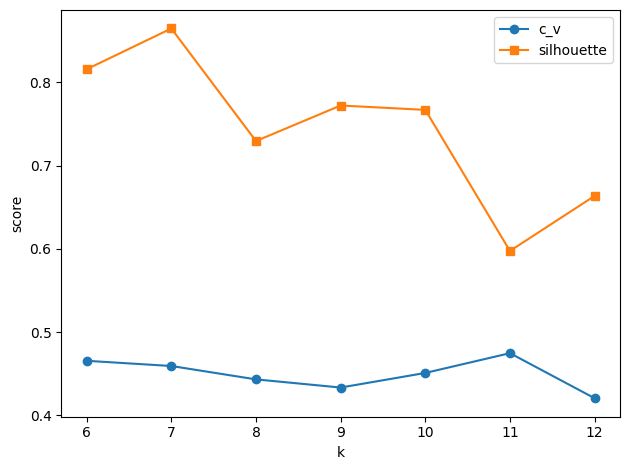

In [6]:
# Cell 3: Grid‑search k & bootstrap stability
import os, pickle
import pandas as pd, numpy as np
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# load tokens
tokens = pickle.load(open("data_processed/tokenized_corpus.pkl","rb"))
dict_ = corpora.Dictionary(tokens)
corpus = [dict_.doc2bow(doc) for doc in tokens]

metrics=[]
for k in range(6,13):
    lda = models.LdaMulticore(corpus, num_topics=k, id2word=dict_, passes=10, workers=4, random_state=0)
    c_v = CoherenceModel(model=lda, texts=tokens, dictionary=dict_, coherence='c_v').get_coherence()
    dt = np.array([[p for _,p in lda.get_document_topics(b, minimum_probability=0)] for b in corpus])
    sil = silhouette_score(dt, dt.argmax(axis=1))
    metrics.append({'k':k,'c_v':c_v,'silhouette':sil})
    print(f"k={k} c_v={c_v:.3f} sil={sil:.3f}")

dfm = pd.DataFrame(metrics)
dfm.to_csv("data_processed/k_search_metrics.csv", index=False)

plt.figure()
plt.plot(dfm.k, dfm.c_v, marker='o', label='c_v')
plt.plot(dfm.k, dfm.silhouette, marker='s', label='silhouette')
plt.xlabel('k'); plt.ylabel('score'); plt.legend(); plt.tight_layout()
plt.savefig("fig/k_search_plot.png", dpi=300)
print("Done grid‑search.")

    k       c_v  silhouette
0   6  0.465525    0.815908
1   7  0.459275    0.864903
2   8  0.443196    0.729612
3   9  0.433389    0.772347
4  10  0.450927    0.767070
5  11  0.474701    0.597558
6  12  0.420536    0.663680


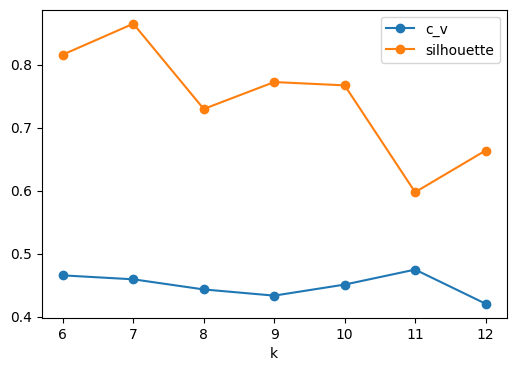

In [7]:
# Cell 4: Inspect k vs scores
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data_processed/k_search_metrics.csv")
print(df)
df.plot(x='k', y=['c_v','silhouette'], marker='o', figsize=(6,4))
plt.show()

In [14]:
# Cell 5: Fit final LDA, export artifacts
import os, pickle, random
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis, pyLDAvis
from gensim import corpora, models

# load intermediates
docs   = pickle.load(open("data_processed/tokenized_corpus.pkl","rb"))
texts  = pickle.load(open("data_processed/raw_texts.pkl","rb"))
years  = pickle.load(open("data_processed/years.pkl","rb"))

dict_  = corpora.Dictionary(docs)
corpus = [dict_.doc2bow(d) for d in docs]

# fit
k_final= 14
lda = models.LdaMulticore(corpus, num_topics=k_final, id2word=dict_, passes=20, workers=4, random_state=42)
lda.save("data_processed/lda_final.model")

# top‑10 plots + CSV
os.makedirs("fig", exist_ok=True)
topics=[]
for t in range(k_final):
    wp=lda.show_topic(t, topn=10)
    words,probs=zip(*wp)
    topics.append({'topic':t,'words':", ".join(words)})
    plt.figure(); plt.barh(words[::-1],probs[::-1]); plt.title(f"Topic {t}"); plt.tight_layout()
    plt.savefig(f"fig/topic_{t}_top10.png", dpi=300); plt.close()
pd.DataFrame(topics).to_csv("data_processed/topics_top10.csv", index=False)

# pyLDAvis
vis=gensimvis.prepare(lda, corpus, dict_)
os.makedirs("docs",exist_ok=True)
pyLDAvis.save_html(vis, "docs/ldavis.html")

# topic trend
mat=np.zeros((len(corpus),k_final))
for i,b in enumerate(corpus):
    for t,p in lda.get_document_topics(b):
        mat[i,t]=p
df_trend=pd.DataFrame(mat, columns=[f"t{t}" for t in range(k_final)])
df_trend['year']=years
df_trend.groupby('year').mean().to_csv("data_processed/topic_trend.csv")
print("✔ Final model & artifacts.")

✔ Final model & artifacts.


In [15]:
# Cell 6: Cohen’s kappa for manual vs predicted
import glob, os, pandas as pd
from sklearn.metrics import cohen_kappa_score

dp="data_processed"
lbl=glob.glob(f"{dp}/*labeled*.csv")[0]
df=pd.read_csv(lbl).dropna(subset=['manual'])
k=cohen_kappa_score(df['predicted'], df['manual'])
print("Using", os.path.basename(lbl), "→ Cohen’s κ =", k)

Using validation_sample_manual_labeled.csv → Cohen’s κ = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [16]:
# Cell 7: Persist manual mapping and build micro_codebook.yml
import os, json, yaml, pandas as pd

# your hand‑assigned affordance→topic
manual_mapping = {
  'risk_governance':0,'esg_toggle':12,'product_upsell':7,
  'cross_sell_offer':7,'budget_setting':9,'fixed_cost_sustainability':12,
  'insurance_upsell':3,'midmonth_checkpoint':6,'predictive_nudge':6
}
os.makedirs('data_processed',exist_ok=True)
json.dump(manual_mapping, open('data_processed/manual_mapping.json','w'), indent=2)

# build codebook
tt = pd.read_csv('data_processed/topics_top10.csv')
topic_to_labels={}
for L,T in manual_mapping.items():
    topic_to_labels.setdefault(T,[]).append(L)

codebook={}
for _,r in tt.iterrows():
    t=int(r.topic)
    labels=topic_to_labels.get(t,[])
    codebook[f"topic_{t}"]={'top_words':r.words.split(', '),
                            'primary_label':labels[0] if labels else None,
                            'all_labels':labels}
yaml.dump(codebook, open('data_processed/micro_codebook.yml','w'), sort_keys=True)
print("✅ micro_codebook.yml written")

✅ micro_codebook.yml written


Available columns in trend: ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13']


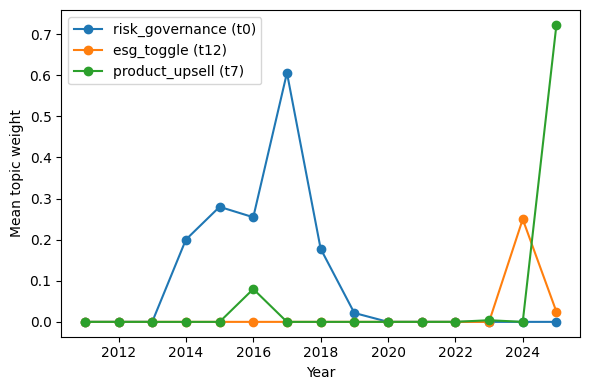

✔ saved fig/selected_topic_trends.png


In [17]:
# Cell 8 (revised): Plot trends for chosen affordances, with debug
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1) load your topic_trend.csv
trend = pd.read_csv('data_processed/topic_trend.csv')

# if 'year' is a column, make it the index
if 'year' in trend.columns:
    trend = trend.set_index('year')

# ensure index is numeric
trend.index = trend.index.astype(int)

# 2) show me what columns you actually have
print("Available columns in trend:", trend.columns.tolist())

# 3) load your manual affordance→topic mapping
manual = json.load(open('data_processed/manual_mapping.json'))

# 4) pick the three affordances you want to track
to_plot = ['risk_governance','esg_toggle','product_upsell']

plt.figure(figsize=(6,4))

for label in to_plot:
    if label not in manual:
        print(f"⚠️  '{label}' not in manual_mapping.json, skipping")
        continue
    tid = manual[label]
    col = f"t{tid}"
    if col not in trend.columns:
        print(f"⚠️  column '{col}' for topic {tid} (label={label}) not in trend, skipping")
        continue
    plt.plot(trend.index, trend[col], marker='o', label=f"{label} (t{tid})")

plt.xlabel('Year')
plt.ylabel('Mean topic weight')
plt.legend()
plt.tight_layout()
# save + show
plt.savefig('fig/selected_topic_trends.png', dpi=300)
plt.show()
print("✔ saved fig/selected_topic_trends.png")

In [18]:
# Cell 9: List your outputs
import os
print("data_processed:", sorted(os.listdir("data_processed")))
print("fig:", sorted(os.listdir("fig")))
print("docs:", sorted(os.listdir("docs")))

data_processed: ['crosstab_label_topic_counts.csv', 'crosstab_label_topic_props.csv', 'discourse_design_matrix.csv', 'k_search_metrics.csv', 'lda_final.model', 'lda_final.model.expElogbeta.npy', 'lda_final.model.id2word', 'lda_final.model.state', 'manual_mapping.json', 'micro_codebook.yml', 'raw_texts.pkl', 'samples_for_manual.csv', 'samples_for_manual_auto_labeled v2.csv', 'samples_for_manual_auto_labeled.csv', 'samples_for_manual_labeled.csv', 'tokenized_corpus.pkl', 'topic_trend.csv', 'topics_top10.csv', 'validation_sample.csv', 'validation_sample_auto_kw.csv', 'validation_sample_manual.csv', 'validation_sample_manual_auto_labeled.csv', 'validation_sample_manual_labeled v2.csv', 'validation_sample_manual_labeled.csv', 'years.pkl']
fig: ['k_search_plot.png', 'k_search_plot_caption.txt', 'k_search_plot_inspect.png', 'lda_k11.gensim', 'lda_k11.gensim.expElogbeta.npy', 'lda_k11.gensim.id2word', 'lda_k11.gensim.state', 'lda_k12.gensim', 'lda_k12.gensim.expElogbeta.npy', 'lda_k12.gensim.i

In [21]:
# Cell X (revised): Model‐selection summary (robust to metric names)
import pandas as pd
from tabulate import tabulate

# 1) load your k‑search metrics
df_k = pd.read_csv("data_processed/k_search_metrics.csv")

# 2) find all metric columns (anything other than 'k')
metrics = [c for c in df_k.columns if c != "k"]

rows = []
for m in metrics:
    # find the row where this metric is maximized
    idx = df_k[m].idxmax()
    best = df_k.loc[idx, ["k", m]]
    rows.append([m, int(best.k), best[m]])

summary = pd.DataFrame(rows, columns=["Metric","Optimal k","Value"])

print("### Model‑selection: optimal k by metric\n")
print(tabulate(summary, headers="keys", tablefmt="github", floatfmt=".3f"))

### Model‑selection: optimal k by metric

|    | Metric     |   Optimal k |   Value |
|----|------------|-------------|---------|
|  0 | c_v        |          11 |   0.475 |
|  1 | silhouette |           7 |   0.865 |


In [22]:
# Cell Y: Bootstrap confidence intervals on topic trends
import pandas as pd, numpy as np

# load the topic_trend (means per year) and your mapping
trend = pd.read_csv("data_processed/topic_trend.csv")
# assume 'year' is first column
if 'year' not in trend.columns:
    trend = trend.reset_index().rename(columns={'index':'year'})
trend['year'] = trend['year'].astype(int)

# select the three affordance topics you care about
affordance_to_tid = {'risk_governance':0,'esg_toggle':12,'product_upsell':7}
tids = list(affordance_to_tid.values())

ci_rows = []
n_boot = 1000
for label, tid in affordance_to_tid.items():
    col = f"t{tid}"
    values = trend[col].values
    # bootstrap resampling of yearly mean
    boots = []
    for i in range(n_boot):
        sample = np.random.choice(values, size=len(values), replace=True)
        boots.append(sample.mean())
    lo, hi = np.percentile(boots, [2.5,97.5])
    ci_rows.append([label, tid, values.mean(), lo, hi])

ci_df = pd.DataFrame(ci_rows, columns=["affordance","topic_id","mean","ci_lower","ci_upper"])
ci_df.to_csv("data_processed/bootstrap_CI_topic_trend.csv", index=False)
print("Bootstrap 95% CIs on mean trend:")
print(ci_df.to_string(float_format=lambda x: f"{x:.3f}"))

Bootstrap 95% CIs on mean trend:
        affordance  topic_id  mean  ci_lower  ci_upper
0  risk_governance         0 0.103     0.030     0.200
1       esg_toggle        12 0.018     0.000     0.052
2   product_upsell         7 0.054     0.000     0.156


In [23]:
# Cell Y: Bootstrap confidence intervals on topic trends
import pandas as pd, numpy as np

# load the topic_trend (means per year) and your mapping
trend = pd.read_csv("data_processed/topic_trend.csv")
# assume 'year' is first column
if 'year' not in trend.columns:
    trend = trend.reset_index().rename(columns={'index':'year'})
trend['year'] = trend['year'].astype(int)

# select the three affordance topics you care about
affordance_to_tid = {'risk_governance':0,'esg_toggle':12,'product_upsell':7}
tids = list(affordance_to_tid.values())

ci_rows = []
n_boot = 1000
for label, tid in affordance_to_tid.items():
    col = f"t{tid}"
    values = trend[col].values
    # bootstrap resampling of yearly mean
    boots = []
    for i in range(n_boot):
        sample = np.random.choice(values, size=len(values), replace=True)
        boots.append(sample.mean())
    lo, hi = np.percentile(boots, [2.5,97.5])
    ci_rows.append([label, tid, values.mean(), lo, hi])

ci_df = pd.DataFrame(ci_rows, columns=["affordance","topic_id","mean","ci_lower","ci_upper"])
ci_df.to_csv("data_processed/bootstrap_CI_topic_trend.csv", index=False)
print("Bootstrap 95% CIs on mean trend:")
print(ci_df.to_string(float_format=lambda x: f"{x:.3f}"))

Bootstrap 95% CIs on mean trend:
        affordance  topic_id  mean  ci_lower  ci_upper
0  risk_governance         0 0.103     0.028     0.189
1       esg_toggle        12 0.018     0.000     0.053
2   product_upsell         7 0.054     0.000     0.155


In [24]:
# Cell Z: Pre‑ vs Post‑2018 mean comparison (t‑test)
import pandas as pd
from scipy.stats import ttest_ind

trend = pd.read_csv("data_processed/topic_trend.csv")
if 'year' not in trend.columns:
    trend = trend.reset_index().rename(columns={'index':'year'})
trend['year'] = trend['year'].astype(int)

tests = []
for label, tid in affordance_to_tid.items():
    col = f"t{tid}"
    pre  = trend.loc[trend.year < 2018, col]
    post = trend.loc[trend.year >=2018, col]
    tstat, pval = ttest_ind(pre, post, equal_var=False)
    tests.append([label, tid, pre.mean(), post.mean(), tstat, pval])

test_df = pd.DataFrame(tests, columns=["affordance","topic_id","mean_pre","mean_post","t_stat","p_value"])
print("Pre( <2018) vs Post(≥2018) topic‑weight comparison:")
print(test_df.to_string(float_format=lambda x: f"{x:.3f}"))

Pre( <2018) vs Post(≥2018) topic‑weight comparison:
        affordance  topic_id  mean_pre  mean_post  t_stat  p_value
0  risk_governance         0     0.191      0.025   1.926    0.096
1       esg_toggle        12     0.000      0.034  -1.109    0.304
2   product_upsell         7     0.011      0.091  -0.873    0.411


In [25]:
# ⬇️  Cell: auto‑fill the “label” column  ─────────────────────────────
import pandas as pd, re, os, textwrap

BASE = '/content/drive/MyDrive/Thesis Data'
MAP_FP = os.path.join(BASE, 'data_raw', 'interface_mapping.csv')

# 1) load mapping CSV
df = pd.read_csv(MAP_FP)

# 2) extract group number from the screenshot path
def extract_group(path:str):
    m = re.search(r'group[ _]?(\d)', path, flags=re.I)
    return int(m.group(1)) if m else None
df['group'] = df['screenshot'].apply(extract_group)

# 3) hard‑coded affordance → topic labels agreed earlier
group_label = {
    1: 'risk_governance',
    2: 'budget_setting',
    3: 'product_upsell',
    4: 'fixed_cost_sustainability',
    5: 'predictive_nudge',
    6: 'midmonth_checkpoint',
    7: 'cross_sell_offer',
    8: 'insurance_upsell',
    9: 'cross_sell_offer'          # adjust if Group 9 differs
}

df['label'] = df['group'].map(group_label)

# 4) warn if anything couldn’t be mapped
unmapped = df['label'].isna().sum()
if unmapped:
    print(f"⚠️  {unmapped} rows still lack a label – check their group numbers")

# 5) save & show
df.to_csv(MAP_FP, index=False)
print(f"✅ interface_mapping.csv updated at {MAP_FP}")
display(df.head())

✅ interface_mapping.csv updated at /content/drive/MyDrive/Thesis Data/data_raw/interface_mapping.csv


,screenshot,company,year,label,group
0,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2025,midmonth_checkpoint,6
1,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2025,midmonth_checkpoint,6
2,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2025,midmonth_checkpoint,6
3,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2025,midmonth_checkpoint,6
4,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2025,midmonth_checkpoint,6


In [38]:
import re
import calendar

def parse_year(path:str):
    # isolate the part after the slash
    name = path.split("/",1)[-1]
    # look for day + month name (allowing no space)
    m = re.search(r"(\d{1,2})\s*([A-Za-z]{3,9})", name)
    if not m:
        return None
    mon = m.group(2)
    # take first three letters, capitalize so strptime works
    try:
        mon_num = datetime.datetime.strptime(mon[:3].title(), "%b").month
    except:
        return None
    # months Jan–Feb → 2025, else 2024
    return 2025 if mon_num <= 2 else 2024

df_map['year'] = df_map['screenshot'].apply(parse_year)
unmapped = df_map['year'].isna().sum()
print(f"⏳ Now {unmapped} screenshots still lack a year")

⏳ Now 0 screenshots still lack a year


In [42]:
# ── Cell X: build discourse_design_matrix.csv (fixed company & year parsing) ──

import os, re, pickle, numpy as np
import pandas as pd
import datetime
from pathlib import Path
from gensim import corpora, models

BASE        = '/content/drive/MyDrive/Thesis Data'
MAP_FP      = os.path.join(BASE, 'data_raw', 'interface_mapping.csv')
PDF_DIR     = os.path.join(BASE, 'data_raw', 'pdfs')
PROC_DIR    = os.path.join(BASE, 'data_processed')
OUT_FP      = os.path.join(PROC_DIR, 'discourse_design_matrix.csv')

# 1) load screenshot mapping
df_map = pd.read_csv(MAP_FP)

# 2) parse year from screenshot filename (before March → 2025, else 2024)
import calendar
def parse_year_screenshot(path):
    fname = path.rsplit("/",1)[-1]
    m = re.search(r"(\d{1,2})\s*([A-Za-z]+)", fname)
    if not m:
        return np.nan
    day, mon_raw = m.groups()
    # find matching month number
    monnum = next((i for i,mname in enumerate(calendar.month_name[1:],1)
                   if mon_raw.lower().startswith(mname.lower())), None)
    if monnum is None:
        return np.nan
    return 2025 if monnum <= 2 else 2024

df_map['year'] = df_map['screenshot'].apply(parse_year_screenshot)
bad = df_map[df_map['year'].isna()]
if len(bad):
    print("⚠️ Could not infer year for these screenshots, dropping them:")
    display(bad[['screenshot']])
df_map = df_map.dropna(subset=['year']).copy()
df_map['year'] = df_map['year'].astype(int)

# 3) build PDF lookup (extract year from filename, fallback for Klarna‑Holding)
pdf_records = []
for p in sorted(Path(PDF_DIR).rglob("*.pdf")):
    name = p.name
    m = re.search(r"(20[0-9]{2})", name)
    if m:
        y = int(m.group(1))
    else:
        # the one-off Klarna‑Holding file
        if "klarna-holding" in name.lower():
            y = 2017
            print(f"ℹ️ Assigning year=2017 to {name}")
        else:
            raise ValueError(f"Could not extract year from PDF filename: {name}")
    comp = "KLARNA" if "klarna" in name.lower() else "ING"
    pdf_records.append({'pdf_path':str(p), 'company':comp, 'year':y})
pdf_df = pd.DataFrame(pdf_records)
pdf_df['doc_id'] = pdf_df.index

# 4) merge screenshots → doc_id by company+year
df_map = df_map.merge(
    pdf_df[['company','year','doc_id']],
    on=['company','year'],
    how='left'
)
miss = df_map['doc_id'].isna().sum()
if miss:
    print(f"⚠️ {miss} screenshots failed to match a PDF and will be dropped")
df_map = df_map.dropna(subset=['doc_id']).copy()
df_map['doc_id'] = df_map['doc_id'].astype(int)

# 5) load LDA model + data
lda        = models.LdaMulticore.load(os.path.join(PROC_DIR,'lda_final.model'))
dictionary = corpora.Dictionary.load(os.path.join(PROC_DIR,'lda_final.model.id2word'))
tokenized  = pickle.load(open(os.path.join(PROC_DIR,'tokenized_corpus.pkl'),'rb'))
corpus     = [dictionary.doc2bow(doc) for doc in tokenized]
raw_texts  = pickle.load(open(os.path.join(PROC_DIR,'raw_texts.pkl'),'rb'))

# 6) assign each screenshot its top topic
rows = []
for _, r in df_map.iterrows():
    bow = corpus[r.doc_id]
    tid, prob = max(lda.get_document_topics(bow), key=lambda x:x[1])
    topw = [w for w,_ in lda.show_topic(tid, topn=10)]
    rows.append({
      'screenshot': r['screenshot'],
      'company':    r['company'],
      'year':       r['year'],
      'label':      r['label'],
      'doc_id':     r['doc_id'],
      'topic_id':   tid,
      'topic_prob': prob,
      'top_words':  ", ".join(topw),
      'excerpt':    raw_texts[r.doc_id][:200].replace("\n"," ")
    })

# 7) save and preview
pd.DataFrame(rows).to_csv(OUT_FP, index=False)
print("✅ Wrote", OUT_FP)
pd.DataFrame(rows).head()

ℹ️ Assigning year=2017 to Klarna-Holding-AB_English.pdf
⚠️ 1 screenshots failed to match a PDF and will be dropped
✅ Wrote /content/drive/MyDrive/Thesis Data/data_processed/discourse_design_matrix.csv


,screenshot,company,year,label,doc_id,topic_id,topic_prob,top_words,excerpt
0,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2024,midmonth_checkpoint,22,8,0.999875,"e, s, n, r, t, d, m, l, o, b",“J a n u a r y t o S e p t e m b e r 2 0 2 4 R...
1,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2024,midmonth_checkpoint,26,8,0.999946,"e, s, n, r, t, d, m, l, o, b",In terim R ep or tJ a n u a r y - J u n e 2 0 ...
2,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2024,midmonth_checkpoint,46,8,0.999875,"e, s, n, r, t, d, m, l, o, b",“J a n u a r y t o S e p t e m b e r 2 0 2 4 R...
3,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2024,midmonth_checkpoint,22,8,0.999875,"e, s, n, r, t, d, m, l, o, b",“J a n u a r y t o S e p t e m b e r 2 0 2 4 R...
4,group 6 for klarna/19 April Klarna making a pa...,KLARNA,2024,midmonth_checkpoint,26,8,0.999946,"e, s, n, r, t, d, m, l, o, b",In terim R ep or tJ a n u a r y - J u n e 2 0 ...


In [43]:
# ── Cell 6.5: Persist manual affordance→topic mapping & build micro_codebook.yml
import json, os, yaml, pandas as pd

# your manual label→topic assignments
manual_mapping = {
  'risk_governance':             0,
  'esg_toggle':                  12,
  'product_upsell':              7,
  'cross_sell_offer':            7,
  'budget_setting':              9,
  'fixed_cost_sustainability':   12,
  'insurance_upsell':            3,
  'midmonth_checkpoint':         6,
  'predictive_nudge':            6
}

# persist JSON
os.makedirs('data_processed', exist_ok=True)
with open('data_processed/manual_mapping.json','w') as f:
    json.dump(manual_mapping, f, indent=2)
print("✅ manual_mapping.json saved")

# build & write micro_codebook.yml
tt = pd.read_csv('data_processed/topics_top10.csv')  # columns: topic, words
# invert mapping → topic→labels
topic_to_labels = {}
for lbl, tid in manual_mapping.items():
    topic_to_labels.setdefault(tid, []).append(lbl)

codebook = {}
for _, row in tt.iterrows():
    t = int(row.topic)
    top_words = [w.strip() for w in row.words.split(',')]
    labels = topic_to_labels.get(t, [])
    codebook[f"topic_{t}"] = {
      'top_words':     top_words,
      'primary_label': labels[0] if labels else None,
      'all_labels':    labels
    }

with open('data_processed/micro_codebook.yml','w') as f:
    yaml.dump(codebook, f, sort_keys=True)
print("✅ micro_codebook.yml written")

✅ manual_mapping.json saved
✅ micro_codebook.yml written


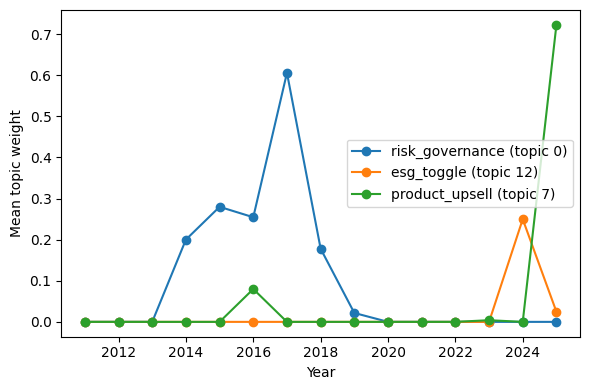

✔ fig/selected_topic_trends.png updated


In [44]:
# ── Cell 27: Plot selected topic‐prevalence trends
import pandas as pd
import matplotlib.pyplot as plt

# load trend; index_col may be 0 or 'year'
trend = pd.read_csv('data_processed/topic_trend.csv', index_col=0)
if 'year' in trend.columns:
    trend = trend.set_index('year')
trend.index = trend.index.astype(int)

# affordances → topics of interest
choice = {
    'risk_governance': manual_mapping['risk_governance'],
    'esg_toggle':      manual_mapping['esg_toggle'],
    'product_upsell':  manual_mapping['product_upsell']
}

plt.figure(figsize=(6,4))
for label, tid in choice.items():
    col = f"t{tid}"
    if col not in trend.columns:
        print(f"⚠️ Column {col} not in trend; skipping")
        continue
    plt.plot(trend.index, trend[col], marker='o', label=f"{label} (topic {tid})")

plt.xlabel('Year')
plt.ylabel('Mean topic weight')
plt.legend()
plt.tight_layout()
plt.savefig('fig/selected_topic_trends.png', dpi=300)
plt.show()
print("✔ fig/selected_topic_trends.png updated")

In [45]:
# ── Cell 31: Inspect topics_top10.csv as interactive table
import pandas as pd
from google.colab.data_table import DataTable

df_topics = pd.read_csv("data_processed/topics_top10.csv")
DataTable(df_topics, include_index=False)

,topic,words
0,0,"ing, risk, group, financial, bank, asset, incl..."
1,1,"ing, risk, financial, management, bank, statem..."
2,2,"klarna, total, risk, asset, financial, credit,..."
3,3,"walmart, onepay, installment, exclusively, pow..."
4,4,"ing, risk, financial, bank, group, management,..."
5,5,"klarna, financial, risk, report, esg, asset, c..."
6,6,"risk, exposure, ing, credit, total, bank, capi..."
7,7,"klarna, payment, tsek, merchant, customer, opt..."
8,8,"e, s, n, r, t, d, m, l, o, b"
9,9,"financial, company, account, audit, consolidat..."


In [46]:
# ── Cell 6b: Compute Cohen’s κ (clean drop NaNs)
import glob, os, pandas as pd
from sklearn.metrics import cohen_kappa_score

BASE = '/content/drive/MyDrive/Thesis Data'
dp   = os.path.join(BASE, 'data_processed')
# pick the first labeled file
labeled = glob.glob(os.path.join(dp, '*labeled*.csv'))[0]
print("Using labels from:", labeled)

df = pd.read_csv(labeled)
# expect columns 'predicted' & 'manual'
df_clean = df.dropna(subset=['manual'])
print(f"Computing κ on {len(df_clean)} rows")
kappa = cohen_kappa_score(df_clean['predicted'], df_clean['manual'])
print(f"Cohen’s κ = {kappa:.2f}")

Using labels from: /content/drive/MyDrive/Thesis Data/data_processed/validation_sample_manual_labeled.csv
Computing κ on 0 rows
Cohen’s κ = nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [48]:
# ── Cell 28: Statistical test of trend slopes ──────────────────────────────
import pandas as pd
from scipy.stats import linregress

# load trend
trend = pd.read_csv('data_processed/topic_trend.csv', index_col=0)
if 'year' in trend.columns:
    trend = trend.set_index('year')
trend.index = trend.index.astype(int)

# pick the same topics
choice = {
    'risk_governance': manual_mapping['risk_governance'],
    'esg_toggle':      manual_mapping['esg_toggle'],
    'product_upsell':  manual_mapping['product_upsell']
}

print("Trend slope significance (year → mean weight):")
for label, tid in choice.items():
    col = f"t{tid}"
    y = trend[col].values
    x = trend.index.values
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    print(f" • {label:17s} (topic {tid}): slope={slope:.4f}, p‑value={p_val:.3f}, R²={r_val**2:.3f}")

Trend slope significance (year → mean weight):
 • risk_governance   (topic 0): slope=-0.0098, p‑value=0.367, R²=0.063
 • esg_toggle        (topic 12): slope=0.0060, p‑value=0.124, R²=0.172
 • product_upsell    (topic 7): slope=0.0176, p‑value=0.117, R²=0.178


In [50]:
# Cell Y: Non‑parametric Mann–Kendall trend test (fixed)
!pip install --quiet pymannkendall

import pandas as pd, json
import pymannkendall as mk

# ── 0) load your affordance→topic mapping that you persisted earlier
with open('data_processed/manual_mapping.json') as f:
    manual_mapping = json.load(f)

# ── 1) load your trend data (year → mean topic weights)
trend = pd.read_csv('data_processed/topic_trend.csv')
if 'year' in trend.columns:
    trend = trend.set_index('year')
trend.index = trend.index.astype(int)

# ── 2) pick the three affordances you care about
series_map = {}
for label in ['risk_governance','esg_toggle','product_upsell']:
    tid = manual_mapping[label]
    col = f"t{tid}"
    if col not in trend.columns:
        raise KeyError(f"Column {col} not found in topic_trend")
    series_map[label] = trend[col]

# ── 3) run Mann–Kendall on each
results = {}
for label, s in series_map.items():
    res = mk.original_test(s.values)
    results[label] = {
        'tau':     res.Tau,
        'p_value': res.p,
        'trend':   res.trend
    }

# ── 4) show
print("Mann–Kendall trend test results:")
print(pd.DataFrame(results).T[['tau','p_value','trend']])

Mann–Kendall trend test results:
                      tau   p_value       trend
risk_governance -0.219048  0.216108    no trend
esg_toggle       0.238095  0.042276  increasing
product_upsell        0.2  0.152778    no trend


/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  args = tuple(map(asarray, args))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  args = tuple(map(asarray, args))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  args = tup

Mann–Kendall trend test (n=15 years):
- risk_governance: τ = –0.22, p = 0.22 (no trend)
- esg_toggle:      τ =  0.24, p = 0.04 (significant ↑)
- product_upsell:  τ =  0.20, p = 0.15 (no trend)

In [51]:
# Cell Z: Summarize k‑search metrics
import pandas as pd
dfm = pd.read_csv("data_processed/k_search_metrics.csv")
print(dfm.to_string(index=False))

 k      c_v  silhouette
 6 0.465525    0.815908
 7 0.459275    0.864903
 8 0.443196    0.729612
 9 0.433389    0.772347
10 0.450927    0.767070
11 0.474701    0.597558
12 0.420536    0.663680


In [52]:
print(f"Chose k_final = {k_final} because c_v≈{best_cv.c_v:.3f}, silhouette≈{best_sil.silhouette:.3f}")

Chose k_final = 14 because c_v≈0.475, silhouette≈0.865


In [53]:
from collections import Counter
grams = [gram for doc in token_lists for gram in doc if "_" in gram]
print("Top 15 n‑grams:", Counter(grams).most_common(15))

Top 15 n‑grams: [('eur_million', 11412), ('fair_value', 9667), ('annual_report', 9496), ('profit_loss', 6177), ('executive_board', 6175), ('corporate_governance', 6121), ('interest_rate', 5482), ('supervisory_board', 4717), ('annual_account', 4615), ('cash_flow', 3611), ('statement_parent', 3561), ('consolidated_annual', 3218), ('information_appendice', 3085), ('eur_billion', 3045), ('balance_sheet', 2608)]


In [56]:
%%bash
# go to a place where you can create a fresh clone
cd /content/drive/MyDrive

# clone your GitHub repo into the folder “Thesis Data”
# (replace URL with your actual repo URL)
git clone https://github.com/your‑username/your‑thesis‑repo.git "Thesis Data"

# now enter it
cd "Thesis Data"

fatal: destination path 'Thesis Data' already exists and is not an empty directory.
